In [1]:
from jupyterthemes import jtplot
jtplot.style()

ModuleNotFoundError: No module named 'jupyterthemes'

# <center>Régression symbolique

## <center>Principe</center>

<center>But : Trouver l'expression analytique qui colle le mieux aux données.</center>

<center>Comment faire ? On peut tester différentes combinaisons de symboles et de fonctions</center>

<center>Un individu = un arbre :

</center> <center><img src="Genetic_Program_Tree.png"></center>

## <center>Différences avec une régression classique</center>

<center>- D'habitude, on trouve les paramètres d’un modèle de base par minimisation d’une fonction de coût.</center>

<center>- Ici, aucun modèle de base n’est fourni.</center>

<center>$$\implies \begin{equation}
\left\{ 
  \begin{aligned}
    &\text{Avantage : pas de biais humain quant au choix du modèle.}\\
    &\text{Désavantage : l'espace de recherche est bien plus grand.} 
  \end{aligned}
  \right.
\end{equation}
$$</center>

## <center>Un exemple simple</center>




In [ ]:
from gplearn.genetic import SymbolicRegressor
function_set=['add', 'sub', 'mul', 'div','cos','sin','neg','inv']
est_gp = SymbolicRegressor(function_set=function_set,
                           population_size=5000, generations=40,
                           tournament_size=20, p_crossover=0.7, 
                           p_point_mutation=0.1,
                           parsimony_coefficient=0.001
                           )

In [1]:
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import graphviz
from sympy import *
import pandas as pd

In [3]:
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}

def create_data(n_samples, functions, beta, sig):
    x = np.linspace(-10, 10, n_samples)
    X = np.column_stack([function(x) for function in functions])
    y_true = np.dot(X, beta)
    sig = sig*(np.max(y_true)-np.min(y_true))
    y = y_true + sig * np.random.normal(size=n_samples)
    return x, y_true, y

def symbolic_regression(x, y,\
                        function_set = ['add', 'sub', 'mul', 'div','cos','sin','neg', 'inv']):

    df = pd.DataFrame(); df['x']=x; df['y']=y;
    X = df[['x']]; y = df['y']; y_true = y
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    est_gp = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=50, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.02, random_state=0)
    est_gp.fit(X_train, y_train)
        
    return est_gp, X_train, X_test, y_train, y_test


On génère des données avec $f(x) = x\cos(x) + 2\sin(x) - \dfrac{x^2}{10}$ et un bruit d'amplitude 5% de celle du signal.

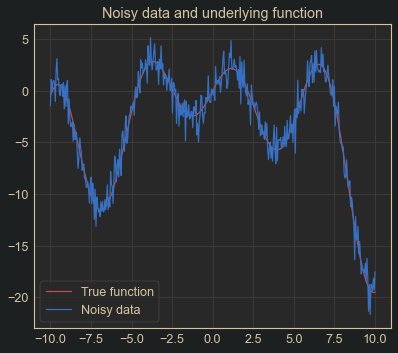

In [7]:
functions = [lambda x : x*np.cos(x), np.sin, lambda x : x**2]
beta = [1, 2, -1/10]
n_samples = 400
x, y_true, y = create_data(n_samples, functions , beta, sig = 0.05)
plt.plot(x, y_true, 'r', x, y, 'b')
plt.legend(["True function", "Noisy data"])
plt.title("Noisy data and underlying function");

In [16]:

est_gp, X_train, X_test, y_train, y_test = symbolic_regression(x, y, \
            function_set = ['add', 'sub', 'mul', 'div','cos','sin','neg'])


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    18.73          669.257       11          3.06514          3.67648      4.17m
   1     6.55          5.41091       11          3.10252           3.7142      3.45m
   2     5.32          5.86167       17          2.98829          2.02162      3.32m
   3     7.09          163.319       17          2.10285          2.03988      3.20m
   4    10.88          8.38074       17          1.70912          1.55082      3.31m
   5    12.85          6.10719       24          1.45407          1.30697      3.50m
   6    15.31          6.78639       19          1.23431          1.43849      3.42m
   7    18.33          7.50206       29          1.11001          0.96594      3.45m
   8    19.46          13.0345       25          0.95449         0.848026  

## Résultats


La fonction originelle était $f(x) = x\cos(x) + 2\sin(x) - \dfrac{x^2}{10}$

L'algorithme a trouvé :

In [17]:

expression = sympify(str(est_gp._program), locals=converter)
expression

-0.100625*X0**2 + X0*cos(X0) + 2*sin(X0)

On peut regarder si cela colle aussi graphiquement :

R2 sur le test set (30%): 0.9679292914926267


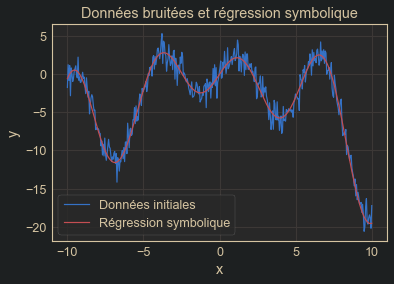

In [18]:
y_pred = est_gp.predict(x[:, np.newaxis])
plt.plot(x, y, 'b', x, y_pred, 'r' )
plt.xlabel("x");
plt.ylabel("y");
plt.title("Données bruitées et régression symbolique");
plt.legend(["Données initiales", "Régression symbolique"])

print('R2 sur le test set (30%):',est_gp.score(X_test,y_test))

## <center>L'article en question</center>

L'article en question souligne l'importance des "références" (benchmarks) : données, choix des algos et des hyperparamètres. Cet article propose de référencer les performances de 14 algorithmes (4 de Symbolic Regression et 10 ML) sur 94 ensembles de données avec la même méthode de choix des hyperparamètres (validation croisée). Le but est de comparer les méthodes selon leurs erreurs d’entraînement/validation et leur temps d’exécution.

<center>Comparaison la plus complète et moins biaisée possible d'algorithmes de régression classiques et symboliques.<center/>

<center>- 14 algorithmes (4 de Symbolic Regression et 10 ML)</center>

<center>- 94 ensembles de données "standards" </center>

<center>- Méthode de choix des hyperparamètres : validation croisée</center>

# <center>Méthodes de régression symbolique</center>

## <center>Multiple regression genetic programming</center>

Association de régression Lasso (Rappel : pénalisation L1, favorise la parcimonie) + Recherche d’arbre classique d'algo génétique. À chaque nœud de l’arbre est attribué un poids qu’on optimise par régression lasso. Rien d’incompréhensible pour la partie algorithme génétique : mutation ponctuelle, croisements de sous-arbres et sélection via NSGA-II.
Algo dispo sur https://flexgp.github.io/gp-learners/ (fichier jar à lancer)

<center>- Principe : attribuer un poids à chaque noeud de l'arbre et les optimiser par régression Lasso</center>

<center>- Rappel : la régression Lasso est "parcimonieuse" $\implies$ peu de termes (théoriquement)</center>

<center>- Mutation ponctuelle
    
 <img src="Point mutation.png"></center>

 <center> - Crossover : Croisements de sous-arbres 
    <center><img src="Sub_treecrossover.png"></center>

<center> - Sélection par NSGA-II</center>

## <center>$\epsilon$-Lexicase selection

Adaptation de la méthode "lexicase selection" à la regression. Initialement, la "Lexicase selection" est une méthode de *sélection* des parents pour des algorithmes de synthèse de programmes.

Point sur les méthodes formelles : Au croisement entre la logique formelle et l'informatique se trouvent les méthodes formelles. On peut dire qu'elles correspondent à des "méta-algorithmes" : prouver la validité (ou une certaine propriété) d'un code informatique (= vérification déductive), créer automatiquement un code respectant une certaine propriété (= synthèse de programme) sont des méthodes formelles. Pour réaliser ce genre de méthodes, on traduit le code informatique en langage formel pour en tirer des propriétés. C'est fascinant de voir que la logique formelle (a priori très abstraite) peut avoir des applications puissantes!


$\epsilon$-lexicase selection : Dans le cadre du Genetic Programming, un individu est évalué par plusieurs tests. La Lexicase selection consiste alors à :
1. Ajouter toute la population courante à l'ensemble des choix possibles
2. Choisir un test au hasard
3. Evaluer la population sur ce test et retirer tous ceux qui n'ont pas le bon résultat
4. Si :
- il ne reste qu'un individu, il est choisit comme parent. 
- il reste plus d'un individu, on réitère 3 avec un autre test choisit au hasard. S'il n'y a plus de tests à choisir, le parent est choisit au hasard parmi les individus restants.

Assez facile à implémenter, cette méthode de sélection est l'une des meilleures en Genetic Programming car elle permet de faire survivre des individus qui réussissent les tests qui sont rarement réussis : les tests agissent comme des filtres d'autant plus puissants qu'ils sont difficiles.

Le problème, c'est qu'en régression, les "tests" sont des évaluations numériques généralement continues (donc non discrètes et encore moins booléenne. Comme le maximum de fitness n'est généralement atteint que par un seul individu, on éliminerait directement tous les individus sauf 1. On a de plus généralement une seule fonction de fitness, ce qui rendrait la procédure inutile.

Pour remédier à ça, on sélectionne simplement les individus "proches du meilleur résultat à un certain $\epsilon$ près". En notant $e(i)$ l'erreur de l'individu i et $e^{\star}$ la plus petite erreur de la population, les tests naturels sont par exemple :
- $e(i) < e^{\star}(1+\epsilon)
- $e(i) < \epsilon
Le problème, c'est qu'alors $\epsilon$ doit être choisit manuellement et est problème dépendant : pour avoir $\epsilon$ dépendant de la difficulté du test (mesurable par MAD(e), mieux que $\sigma(e)$ pour éviter les anomalies), les tests corrigés sont :
- $e(i) < e^{\star} + MAD(e)
- $e(i) < MAD(e)


Le code est fait avec du calcul parallèle (simplement OpenMP) (code en C++) ! Par contre beaucoup de sections parallèles ouvertes, les calculs ont l'air lourds...


Algo dispo sur https://epistasislab.github.io/ellyn/

**<center>Principe de la Lexicase Selection (en Genetic Programming):</center>**
    
1. Ajouter toute la population courante à l'ensemble des choix possibles
2. Choisir un test au hasard
3. Evaluer la population sur ce test et retirer tous ceux qui n'ont pas le bon résultat
4. Si :
    - il ne reste qu'un individu, il est choisit comme parent. 
    - il reste plus d'un individu, on réitère 3 avec un autre test choisit au hasard. S'il n'y a plus de tests à choisir, le parent est choisit au hasard parmi les individus restants.

<center>- Facile à implémenter

<center>- Permet de faire survivre des individus qui réussissent les tests qui sont rarement réussis

<center>- Une des meilleures méthodes de sélection en GP : donne d'excellents résultats

**<center> Adaptation à la régression :</center>**
<center>Les "tests" sont des évaluations numériques généralement non discrètes</center>
   <center>$\implies$ Inutile telle quelle car ne sélectionne qu'un individu, le meilleur

<center>Solution : on sélectionne les meilleurs "à $\epsilon$ près".</center> 

Soit $e(i)$ l'erreur de l'individu i et $e^{\star}$ la plus petite erreur de la population, les tests "naturels" sont:
- $e(i) < e^{\star}(1+\epsilon)$
- $e(i) < \epsilon$

Mais $\epsilon$ choisi manuellement et problème dépendant :
- $e(i) < e^{\star} + MAD(e)$
- $e(i) < MAD(e)$


<center>Reste de l'algorithme classique :

<center>- Mutation ponctuelle

<center>-Croisements de sous-arbres

## Résultats de l'étude
<img src="training.png">

<img src="testing.png">

## <center>Peut-on aller plus loin ?

<center>Cette méthode permet d'avoir une expression analytique des données ! Cela ouvre la porte à tous les résultats d'analyse connus.

<center> En particulier : utilisation possible de l'arithmétique d'intervalles
<br>
<br>
<center> <img src="Interval Arithmetic.jpg">
    

<center> Exemple : $f(x) = x^2 + x + 1,  x \in [-1, 1] \implies f(x) \in [0, 3]$
<br>
<center> (plusieurs résultats possibles selon l'expression...)


<center> Permet donc de connaître un majorant et un minorant d'une fonction...

## <center>En quoi ça aide ?

<center>En permettant l'utilisation de "1/x" (souvent nécessaire pour une bonne description), création d'asymptotes :
<br>   
<br>
<center><img src="BadSR.png">
<br>
<center> <i>Improving Symbolic Regression with Interval Arithmetic and Linear Scaling</i>, Maarten Keijzer

<center>Avec l'arithmétique d'intervalles, on peut déceler lorsqu'il y a un problème d'asymptote (la valeur de la fonction prédite "dépasse les bornes") et pénaliser l'individu $\implies$ méthode "Linear Scaling" proposée dans l'article

<center> Une autre idée non explorée pour l'arithmétique d'intervalles : coupler SR et IBB pour avoir un minimum global théorique d'un dataset (d'après Frédéric Messine, pionnier de l'IBB, c'est une idée à essayer)